<a href="https://colab.research.google.com/github/tangQAQ/LSTM_training/blob/main/V4_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping
from google.colab import drive
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import warnings 

warnings.filterwarnings('ignore')

drive.mount('/content/gdrive')
train_data = pd.read_csv("/content/gdrive/MyDrive/GSPC_train.csv", )
train_data = train_data.drop(['Date'], axis= 1)
train_data = train_data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')
train_data.info()

Mounted at /content/gdrive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23683 entries, 0 to 23682
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       23683 non-null  float32
 1   High       23683 non-null  float32
 2   Low        23683 non-null  float32
 3   Close      23683 non-null  float32
 4   Adj Close  23683 non-null  float32
 5   Volume     23683 non-null  float32
dtypes: float32(6)
memory usage: 555.2 KB


In [ ]:
train_data

,Open,High,Low,Close,Adj Close,Volume
0,17.760000,17.760000,17.760000,17.760000,17.760000,-1.000000e+00
1,17.719999,17.719999,17.719999,17.719999,17.719999,-1.000000e+00
2,17.549999,17.549999,17.549999,17.549999,17.549999,-1.000000e+00
3,17.660000,17.660000,17.660000,17.660000,17.660000,-1.000000e+00
4,17.500000,17.500000,17.500000,17.500000,17.500000,-1.000000e+00
...,...,...,...,...,...,...
23678,4494.169922,4503.939941,4450.040039,4481.149902,4481.149902,4.986830e+09
23679,4474.649902,4521.160156,4450.299805,4500.209961,4500.209961,4.821490e+09
23680,4494.149902,4520.410156,4474.600098,4488.279785,4488.279785,4.083200e+09
23681,4462.640137,4464.350098,4408.379883,4412.529785,4412.529785,4.266290e+09


In [ ]:
def data_split(data, slice_size):
  size = int(len(data) * slice_size)
  train = data[:size]
  val = data[size:]
  return train, val

In [ ]:
def create_sequences(data, sequences):
    X = []
    y = []
    for i in range(sequences, len(data)):
        X.append(data[i-sequences:i, :])
        y.append(data[i, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))

train, val = data_split(train_data, 0.8)

sequences = 15
train_data_scaled = sc.fit_transform(train.iloc[:, 0:5])
val_data_scaled = sc.transform(val.iloc[:, 0:5])

X_train, y_train = create_sequences(train_data_scaled, sequences)
X_val, y_val = create_sequences(val_data_scaled, sequences)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((18931, 15, 5), (18931,), (4722, 15, 5), (4722,))

In [ ]:
print(X_train[1] ,y_train[1])

[[0.01160096 0.00860204 0.00879754 0.00874555 0.00874555]
 [0.01148966 0.00849225 0.00868526 0.00863393 0.00863393]
 [0.01156168 0.00856329 0.00875791 0.00870616 0.00870616]
 [0.01145693 0.00845996 0.00865223 0.00860111 0.00860111]
 [0.01137182 0.00837601 0.00856637 0.00851575 0.00851575]
 [0.01135873 0.00836309 0.00855316 0.00850262 0.00850262]
 [0.01143729 0.00844059 0.00863242 0.00858141 0.00858141]
 [0.0115093  0.00851163 0.00870507 0.00865363 0.00865363]
 [0.01131945 0.00832435 0.00851353 0.00846323 0.00846323]
 [0.01132599 0.0083308  0.00852014 0.00846979 0.00846979]
 [0.01129981 0.00830497 0.00849372 0.00844353 0.00844353]
 [0.01137837 0.00838247 0.00857298 0.00852232 0.00852232]
 [0.01144383 0.00844705 0.00863902 0.00858798 0.00858798]
 [0.01154858 0.00855037 0.0087447  0.00869303 0.00869303]
 [0.01159441 0.00859558 0.00879093 0.00873899 0.00873899]] 0.011470023


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False, dropout=0.2))
model.add(Dense(units=5))

model.compile(optimizer='Adam', loss='mse', metrics='Accuracy')
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks = [callback])

Epoch 1/100
592/592 [==============================] - 12s 14ms/step - loss: 0.0013 - Accuracy: 0.0279 - val_loss: 0.2833 - val_Accuracy: 0.0000e+00
Epoch 2/100
592/592 [==============================] - 4s 7ms/step - loss: 4.0289e-04 - Accuracy: 0.0585 - val_loss: 0.3113 - val_Accuracy: 0.0000e+00
Epoch 3/100
592/592 [==============================] - 5s 8ms/step - loss: 3.8955e-04 - Accuracy: 0.0604 - val_loss: 0.3202 - val_Accuracy: 0.0000e+00
Epoch 4/100
592/592 [==============================] - 5s 8ms/step - loss: 3.3734e-04 - Accuracy: 0.0554 - val_loss: 0.3359 - val_Accuracy: 0.0000e+00
Epoch 5/100
592/592 [==============================] - 4s 8ms/step - loss: 3.0196e-04 - Accuracy: 0.0577 - val_loss: 0.2975 - val_Accuracy: 0.0000e+00
Epoch 6/100
592/592 [==============================] - 5s 8ms/step - loss: 2.8405e-04 - Accuracy: 0.0571 - val_loss: 0.2970 - val_Accuracy: 0.0000e+00
Epoch 7/100
592/592 [==============================] - 4s 7ms/step - loss: 2.4341e-04 - Accuracy

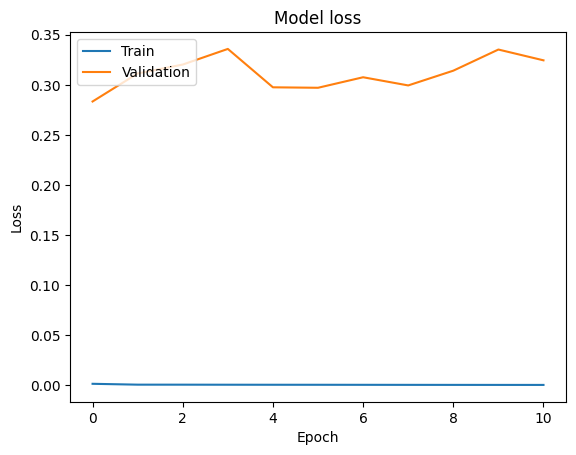

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_train, y_train, batch_size= 32)

592/592 [==============================] - 2s 3ms/step - loss: 1.6983e-04 - Accuracy: 1.5847e-04


[0.00016983201203402132, 0.0001584702404215932]

In [ ]:
test_df = pd.read_csv("/content/gdrive/MyDrive/GSPC_test.csv")

test_data = test_df.copy()
test_data = test_data.drop(['Date'], axis= 1)
test_data_clean = test_data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')

total = pd.concat((train_data.iloc[:, 0:5], test_data_clean.iloc[:, 0:5]), axis=0)
total = total[len(total) - len(test_data_clean) - sequences :].values#.reshape(-1, 1)


preds = list()
days = 10 
sc2 = MinMaxScaler(feature_range=(0,1))

test_data_scaled = sc2.fit_transform(total)
X_test, y_test = create_sequences(test_data_scaled, sequences)
test_predictions = model.predict(X_test)
print(test_predictions.shape)
inverse = sc2.inverse_transform(test_predictions)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23933 entries, 0 to 249
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       23933 non-null  float32
 1   High       23933 non-null  float32
 2   Low        23933 non-null  float32
 3   Close      23933 non-null  float32
 4   Adj Close  23933 non-null  float32
dtypes: float32(5)
memory usage: 654.4 KB
None
8/8 [==============================] - 0s 5ms/step
(250, 5)


In [ ]:
inverse

array([[4485.4004, 4508.093 , 4445.0996, 4500.0933, 4498.9385],
       [4478.5483, 4503.0454, 4438.5493, 4494.322 , 4493.4155],
       [4470.571 , 4496.35  , 4430.3936, 4487.062 , 4486.3237],
       ...,
       [4042.7153, 4080.3428, 3993.3481, 4060.5068, 4069.5312],
       [4055.5894, 4092.7117, 4005.995 , 4072.896 , 4081.8337],
       [4068.1646, 4105.276 , 4018.5867, 4085.3413, 4094.222 ]],
      dtype=float32)

'''
# data_min_: test_data,data_max_:test_data
for i in range(1, days+1):
  test_data_scaled = sc2.fit_transform(test_data)
  #print(f'test_data_scaled:{test_data_scaled}')
  X_test, y_test = create_sequences(test_data_scaled, sequences)
  #print(f'X_test: {X_test.shape}, X_test.shape: {X_test.shape}')
  test_predictions = model.predict(X_test)
  #print(f'test_predictions: {test_predictions}')
  inverse = sc2.inverse_transform(test_predictions)
  #print(f'inverse: {inverse}')
  preds.append(inverse[:, 0])
  #print(preds)
  #print(f'preds: {preds}')
  #test_data.drop(0, inplace=True)
  #print(f'test_data: {test_data}')
  test_data = test_data.append(pd.Series(inverse[-1,0], index=test_data.columns), ignore_index=True)
  #print(f'test_data: {test_data}')

'''

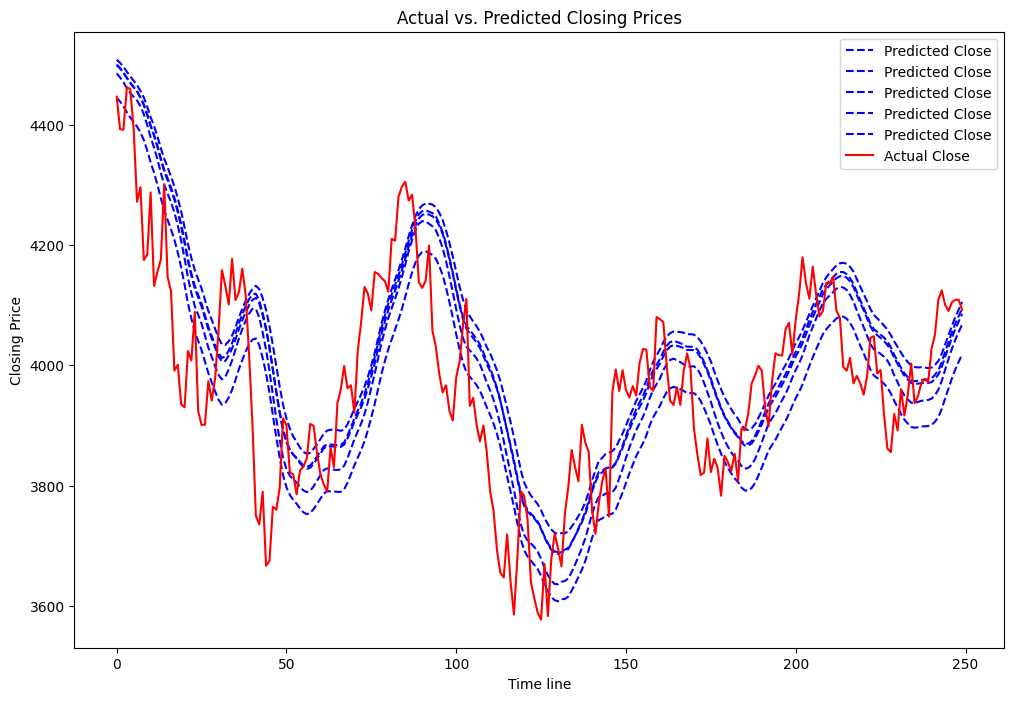

In [ ]:
from numpy.ma import left_shift
import matplotlib.ticker as ticker


limit = sequences + days
Actual_Close = test_data_clean['Close']
seq_Close = test_data_clean['Close'].iloc[:sequences]

result = inverse

plt.figure(figsize=(12, 8))
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Time line')
plt.ylabel('Closing Price')
plt.plot(result, label='Predicted Close', color='b', linestyle='--')
plt.plot(Actual_Close, label='Actual Close', color='r')
ax= plt.gca()
plt.legend()
plt.show()